In [1]:
%matplotlib inline
import cmlreaders as cml
import numpy as np
import seaborn as sns
import pandas as pd
import sys
sys.path.append('/home1/djhalp/pybeh_pd')
import pybeh_pd as pb

In [2]:
all_catfr1_events = cml.CMLReader.load_events(experiments=["catFR1"], data_type='task_events')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/readers.py:250: UserWarning: Changing events session field from 0 to 1 to match data index.
  warnings.warn(f'Changing events session field from {df["session"].unique()[0]} ' +
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/readers.py:250: UserWarning: Changing events session field from 1 to 0 to match data index.
  warnings.warn(f'Changing events session field from {df["session"].unique()[0]} ' +
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/readers.py:250: UserWarning: Changing events session field from 10 to 3 to match data index.
  warnings.warn(f'Changing events session field from {df["session"].unique()[0]} ' +
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/readers.py:250: UserWarning: Changing events session fie

In [3]:
events = all_catfr1_events.query('type == ["WORD", "REC_WORD"]')
events = events[events['list'] > 0] # removing practice lists

In [6]:
#removing subjects who were presented with the same word multiple times (probably repeated data)
word_evs = events.query('type == "WORD"')
n_word_pres = word_evs.groupby(['subject', 'session', 'list', 'item_num'], as_index=False).size()
bad_lists = n_word_pres.query('size > 2')
bad_lists[['subject', 'session', 'list']].drop_duplicates()
bad_subs = bad_lists.subject.unique().tolist()

#drop subjects without 12 items per list
n_list_pres = word_evs.groupby(['subject', 'session', 'list'], as_index=False).size()
bad_lists = n_list_pres.query('size != 12')
bad_subs += bad_lists.subject.unique().tolist()

#drop subjects with no recalls
n_types = events.groupby('subject', as_index=False).agg({'type': 'nunique'})
no_recall_subs = n_types.query('type != 2')
bad_subs += no_recall_subs.subject.unique().tolist()

#drop subjects with messed up recalls
rec_evs = events.query('type == "REC_WORD"')
joint_evs = word_evs.merge(rec_evs[['subject', 'session', 'list', 'category', 'item_name']], how='left', indicator=True)
bad_subs += joint_evs.query('(recalled == 1 and _merge != "both") or (recalled == 0 and _merge == "both")').subject.unique().tolist()

#drop subjects with rare_items
item_sub_df = word_evs.groupby(['item_name'], as_index=False).agg({'subject': 'count'})
rare_items = item_sub_df.query('subject < 20').item_name.unique()
bad_subs += word_evs.query('item_name in @rare_items').subject.unique().tolist()

events.query('subject not in @bad_subs', inplace=True)

In [9]:
word_evs = events.query('type == "WORD"')
rec_evs = events.query('type == "REC_WORD"')

In [10]:
spc_sess_df = word_evs.groupby(['subject', 'session', 'serialpos'], as_index=False).agg({'recalled': 'mean'})
spc_df = spc_sess_df.groupby(['subject', 'serialpos'], as_index=False).agg({'recalled': 'mean'})

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


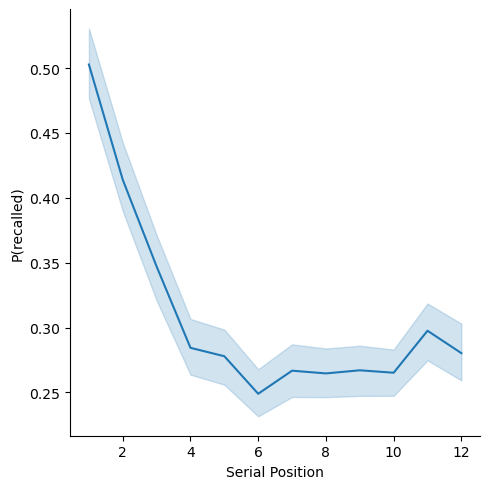

In [11]:
g = sns.relplot(x='serialpos', y='recalled', data=spc_df, kind='line')
g.set(xlabel='Serial Position', ylabel='P(recalled)')

In [12]:
rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
n_list_df = word_evs.groupby(['subject', 'session']).agg({'list': 'nunique'}).reset_index().rename(columns={'list': 'n_lists'})
first_recall_sess_df = rec_evs.query('outpos == 0 and serialpos != -999')
#make sure there are 0s in serialpos that never get recalled first
first_recall_sess_df = first_recall_sess_df.groupby(
    ['subject', 'session', 'serialpos']).agg(
    {'recalled': 'count'}).unstack(fill_value=0).stack().reset_index()
first_recall_sess_df = first_recall_sess_df.merge(n_list_df)
first_recall_sess_df['pfr'] = first_recall_sess_df['recalled'] / first_recall_sess_df['n_lists']
pfr_df = first_recall_sess_df.groupby(['subject', 'serialpos']).agg({'pfr': 'mean'}).reset_index()

/tmp/ipykernel_88677/1371011759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()


/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


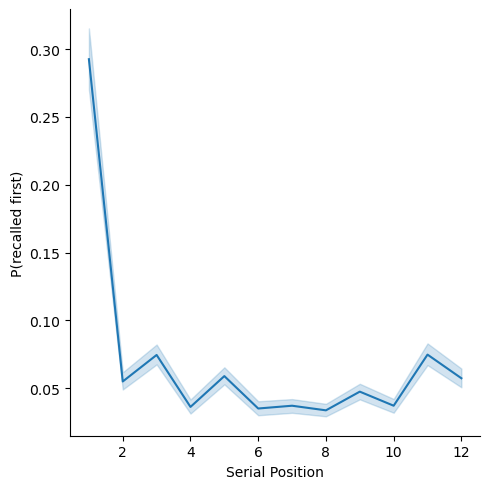

In [13]:
g = sns.relplot(x='serialpos', y='pfr', data=pfr_df, kind='line')
g.set(xlabel='Serial Position', ylabel='P(recalled first)')

In [14]:
spc_sess_df = word_evs.groupby(['subject', 'session', 'serialpos'], as_index=False).agg({'recalled': 'mean'})
spc_df = spc_sess_df.groupby(['subject', 'serialpos'], as_index=False).agg({'recalled': 'mean'})

In [15]:
pb_crp = events.groupby('subject').apply(pb.pd_crp, 
                                itemno_column='item_num').reset_index()

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


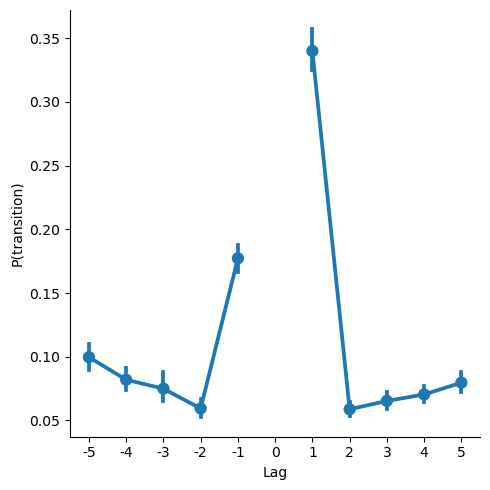

In [16]:
g = sns.catplot(x='lag', y='prob', kind='point', 
                  data=pb_crp.query('lag <= 5 and lag >= -5')
           )
g.set(xlabel='Lag', ylabel='P(transition)')

In [17]:
pb_temp_fact = events.groupby("subject").apply(pb.pd_temp_fact,
                                                   itemno_column='item_num', 
                                                   list_index=['subject', 'session', 'list'], 
                                                   pres_type="WORD", rec_type="REC_WORD", type_column='type'
                                                   ).to_frame(name='temp_fact').reset_index()

pb_temp_fact

,subject,temp_fact
0,R1004D,0.677778
1,R1013E,0.614322
2,R1015J,0.584127
3,R1016M,0.598297
4,R1021D,0.630544
...,...,...
254,R1680T,0.611158
255,R1681J,0.545422
256,R1683A,0.581063
257,R1689J,0.863415


/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


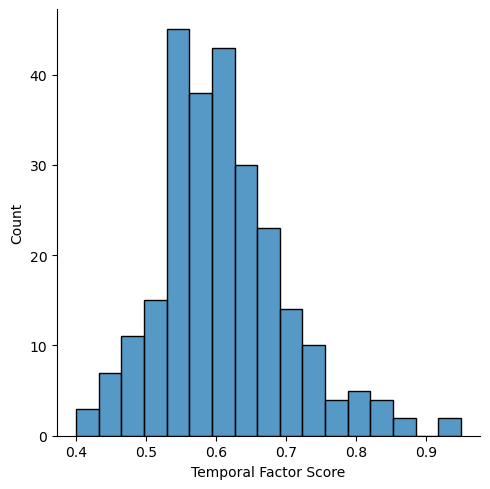

In [18]:
g = sns.displot(x='temp_fact', data=pb_temp_fact)
g.set(xlabel='Temporal Factor Score')

In [19]:
# replace item nums so they are consistent across subjects
item_col = 'item_name'
item_num_col = 'item_num'
item_num_df = events.query('type == "WORD"').drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df['item_num'] = item_num_df['item_num'] + 1
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)

In [20]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

ModuleNotFoundError: No module named 'gensim'

In [ ]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        return keyed_vector.similarity(df[col1].lower(), df[col2].lower())
    except:
        return np.nan

In [ ]:
# get all pairs of items
items = item_num_df[item_col].values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=['wordpool_item_1', 'wordpool_item_2']).to_frame(index=False)

In [ ]:
sem_sim_df

In [ ]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1='wordpool_item_1', 
               col2='wordpool_item_2', 
               keyed_vector=word2vec_vectors)

In [ ]:
sem_sim_df.to_csv('/scratch/djh/catfr1_sem_sim_df.csv', index=False)

In [ ]:
sem_sim_df = pd.read_csv('/scratch/djh/catfr1_sem_sim_df.csv')

In [ ]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on='wordpool_item_1', right_on=item_col).merge(
    item_num_df, left_on='wordpool_item_2', right_on=item_col, suffixes=('_1', '_2')).drop(columns=['wordpool_item_1', 'wordpool_item_2'])

In [ ]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', values='similarity', dropna=False)

In [ ]:
events_new.query('item_num_new == -999')

In [ ]:
pb_sem_crp = events_new.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

In [ ]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', 
                  data=pb_sem_crp)
g.set(xlabel='Similarity Bin', ylabel='P(transition)')

In [ ]:
#using average bin value
pb_sem_crp['avg_sem_bin_mean'] = pb_sem_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
g = sns.relplot(x='avg_sem_bin_mean', y='prob', data=pb_sem_crp, kind='line')
g.set(xlabel='Similarity', ylabel='P(transition)')

In [ ]:
pb_sem_dist_fact = events_new.groupby("subject").apply(pb.pd_dist_fact,
                                                       rec_itemnos=None, 
                                                       itemno_column='item_num_new', 
                                                       list_index=['subject', 'session', 'list'], 
                                                       dist_mat=sem_sims, 
                                                       sim_columns=None, 
                                                       is_similarity=True, 
                                                       dist_columns=None,
                                                       skip_first_n=0,
                                                       pres_type="WORD", rec_type="REC_WORD", type_column='type', ret_counts=False
                                                       ).to_frame(name='sem_fact').reset_index()

pb_sem_dist_fact

In [ ]:
g = sns.displot(x='sem_fact', data=pb_sem_dist_fact)
g.set(xlabel='Semantic Factor Score')

In [ ]:
rec_evs['repeat'] = rec_evs.duplicated(subset=['subject', 'session', 'list', 'item_name'])
rec_evs['correct'] = (rec_evs['repeat'] == False) & (rec_evs['intrusion'] == 0)
rec_evs['next_rectime'] = rec_evs.groupby(['subject', 'session', 'list']).rectime.shift(-1)
rec_evs['next_correct'] = rec_evs.groupby(['subject', 'session', 'list']).correct.shift(-1)
rec_evs['irt'] = rec_evs['next_rectime'] - rec_evs['rectime']
rec_evs.loc[(rec_evs['correct'] == False) | (rec_evs['next_correct'] == False), 'irt'] = np.nan
rec_evs['correct_outpos'] = rec_evs.groupby(['subject', 'session', 'list'])['correct'].cumsum()
rec_evs['n_correct'] = rec_evs.groupby(['subject', 'session', 'list'])['correct_outpos'].transform('max')
rec_evs['irt_s'] = rec_evs['irt'] / 1000
rec_evs['next_serialpos'] = rec_evs.groupby(['subject', 'session', 'list']).serialpos.shift(-1)
rec_evs['transition'] = rec_evs['next_serialpos'] - rec_evs['serialpos']
rec_evs.loc[(rec_evs['correct'] == False) | (rec_evs['next_correct'] == False), 'transition'] = np.nan
rec_evs['next_item_name'] = rec_evs.groupby(['subject', 'session', 'list']).item_name.shift(-1)

In [ ]:
rec_evs = rec_evs.merge(sem_sim_df, how='left', left_on=['item_name', 'next_item_name'], 
                        right_on=['wordpool_item_1', 'wordpool_item_2'])
rec_evs.loc[(rec_evs['correct'] == False) | (rec_evs['next_correct'] == False), 'similarity'] = np.nan

In [ ]:
rec_evs['similarity_bin'] = pd.qcut(rec_evs.similarity, 10, labels=np.arange(0, 10)).astype(float)

In [ ]:
irt_sess_df = rec_evs.groupby(['subject', 'session', 'correct_outpos', 'n_correct'], as_index=False).agg({'irt_s': 'mean'})
irt_df = irt_sess_df.groupby(['subject', 'correct_outpos', 'n_correct'], as_index=False).agg({'irt_s': 'mean'})

In [ ]:
g = sns.catplot(x='correct_outpos', y='irt_s', hue='n_correct', data=irt_df.query('n_correct > 1 and n_correct < 10'), kind='point')
g.set(xlabel='Output Position', ylabel='IRT (s)', title='catFR1')
g._legend.set_title('Total Recalled')

In [ ]:
crl_sess_df = rec_evs.groupby(['subject', 'session', 'transition'], as_index=False).agg({'irt_s': 'mean'})
crl_df = crl_sess_df.groupby(['subject', 'transition'], as_index=False).agg({'irt_s': 'mean'})

In [ ]:
g = sns.catplot(x='transition', y='irt_s', data=crl_df.query('abs(transition) < 6'),
                order=np.arange(-5, 6),
                kind='point')
g.set(xlabel='Transition', ylabel='IRT (s)')

In [ ]:
sem_crl_sess_df = rec_evs.groupby(['subject', 'session', 'similarity_bin'], as_index=False).agg({'irt_s': 'mean'})
sem_crl_df = sem_crl_sess_df.groupby(['subject', 'similarity_bin'], as_index=False).agg({'irt_s': 'mean'})

In [ ]:
g = sns.catplot(x='similarity_bin', y='irt_s', data=sem_crl_df,
                kind='point')
g.set(xlabel='Similarity', ylabel='IRT (s)')